/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/s

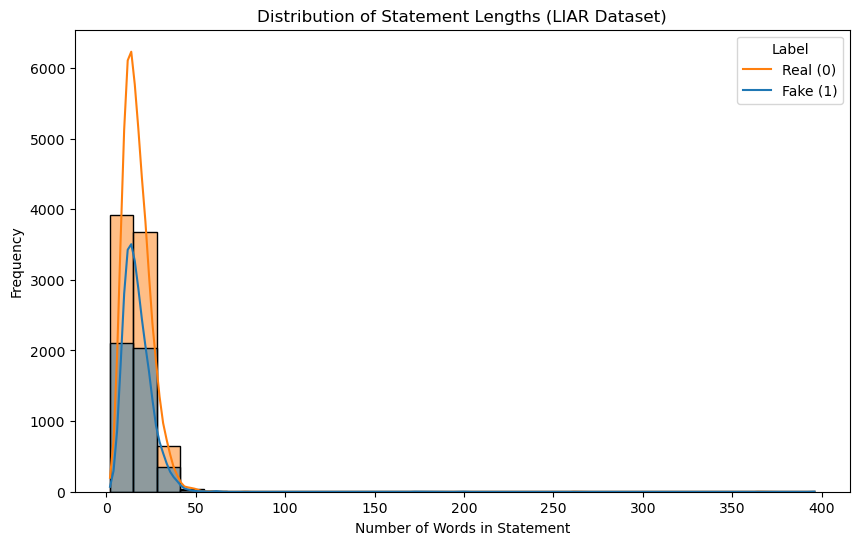

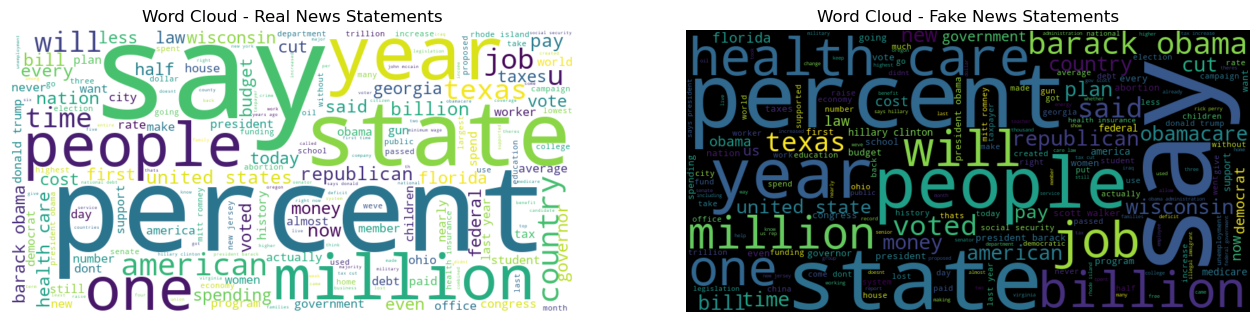


📊 Logistic Regression Performance:
Accuracy: 0.6514
Precision: 0.6798
Recall: 0.8727
F1-Score: 0.7643


In [1]:
# Load Libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load LIAR dataset splits (Adjust path if running locally)
train = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/train.tsv', sep='\t', header=None)
valid = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/valid.tsv', sep='\t', header=None)
test  = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/test.tsv', sep='\t', header=None)

# Define column names based on LIAR dataset
column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job", "state", 
                "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]

# Assign column names
train.columns = column_names
valid.columns = column_names
test.columns = column_names

# Combine all data for EDA
liar_data = pd.concat([train, valid, test], ignore_index=True)

# Convert labels to binary: Real (0) and Fake (1)
def binary_label(label):
    if label in ["true", "mostly-true"]:
        return 0  # Real news
    else:
        return 1  # Fake news

liar_data['binary_label'] = liar_data['label'].apply(binary_label)

# Clean text function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()
    return text

# Apply text cleaning
liar_data['clean_statement'] = liar_data['statement'].astype(str).apply(clean_text)

# Calculate statement lengths
liar_data['statement_length'] = liar_data['clean_statement'].apply(lambda x: len(x.split()))

# 📌 **STEP 2: Exploratory Data Analysis (EDA)**

# Plot statement length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=liar_data, x="statement_length", hue="binary_label", bins=30, kde=True)
plt.title("Distribution of Statement Lengths (LIAR Dataset)")
plt.xlabel("Number of Words in Statement")
plt.ylabel("Frequency")
plt.legend(title="Label", labels=["Real (0)", "Fake (1)"])
plt.show()

# Generate word clouds
real_text = " ".join(liar_data[liar_data['binary_label'] == 0]['clean_statement'])
fake_text = " ".join(liar_data[liar_data['binary_label'] == 1]['clean_statement'])

wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)

# Display word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(wordcloud_real, interpolation='bilinear')
axes[0].set_title("Word Cloud - Real News Statements")
axes[0].axis('off')

axes[1].imshow(wordcloud_fake, interpolation='bilinear')
axes[1].set_title("Word Cloud - Fake News Statements")
axes[1].axis('off')

plt.show()

# 📌 **STEP 3: Train Baseline Model (TF-IDF + Logistic Regression)**

# Feature Extraction: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(liar_data['clean_statement'])

# Prepare target variable
y = liar_data['binary_label']

# Split data into train and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression as a Baseline Model
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_tfidf, y_train)

# Predictions
y_pred = log_reg.predict(X_test_tfidf)

# Evaluate Logistic Regression Performance
logistic_regression_results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred)
}

# Print Results
print("\n📊 Logistic Regression Performance:")
for metric, value in logistic_regression_results.items():
    print(f"{metric}: {value:.4f}")

In [3]:
import torch
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load LIAR dataset (update paths if running locally)
train = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/train.tsv', sep='\t', header=None)
valid = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/valid.tsv', sep='\t', header=None)
test  = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/test.tsv', sep='\t', header=None)

# Define column names
column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job", "state", 
                "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]

train.columns = column_names
valid.columns = column_names
test.columns = column_names

# Combine train, valid, and test datasets
liar_data = pd.concat([train, valid, test], ignore_index=True)

# Convert labels to binary (Real = 0, Fake = 1)
def binary_label(label):
    return 0 if label in ["true", "mostly-true"] else 1

liar_data['binary_label'] = liar_data['label'].apply(binary_label)

# Clean text function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()
    return text

# Apply text cleaning
liar_data['clean_statement'] = liar_data['statement'].astype(str).apply(clean_text)

# Split dataset into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    liar_data['clean_statement'].tolist(), liar_data['binary_label'].tolist(),
    test_size=0.2, random_state=42, stratify=liar_data['binary_label']
)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom PyTorch dataset class for BERT
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Create dataset objects for training and testing
train_dataset = FakeNewsDataset(train_texts, train_labels, tokenizer)
test_dataset = FakeNewsDataset(test_texts, test_labels, tokenizer)

# Load pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert-fake-news",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train BERT Model
print("\n🚀 Training BERT Model...")
trainer.train()

# Evaluate Model
print("\n🎯 Evaluating Model...")

# Make Predictions
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Calculate Performance Metrics
bert_results = {
    "Accuracy": accuracy_score(test_labels, y_pred),
    "Precision": precision_score(test_labels, y_pred),
    "Recall": recall_score(test_labels, y_pred),
    "F1-Score": f1_score(test_labels, y_pred)
}

print("\n📊 BERT Model Performance:")
for metric, value in bert_results.items():
    print(f"{metric}: {value:.4f}")



Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



🚀 Training BERT Model...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.631500,0.622128
2,0.575600,0.627053
3,0.441800,0.750488
4,0.239800,1.043752
5,0.111900,1.296905
6,0.064200,1.648502
7,0.042800,1.931031
8,0.011700,2.204016
9,0.007500,2.365355
10,0.019000,2.444061


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anac


🎯 Evaluating Model...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 BERT Model Performance:
Accuracy: 0.6475
Precision: 0.6502
Recall: 0.9861
F1-Score: 0.7837


Using device: cuda


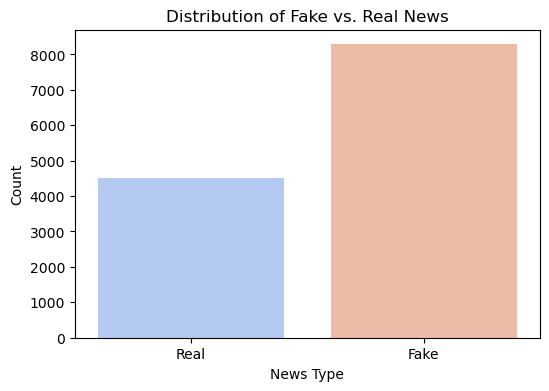

/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


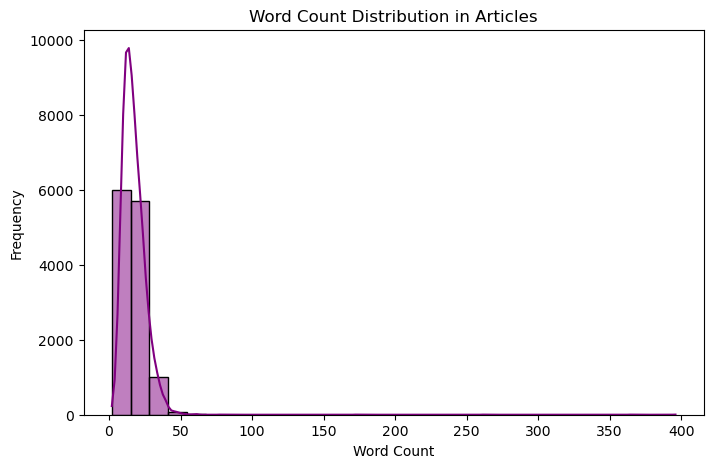

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



🚀 Training BERT Model...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.640600,0.628768
2,0.561400,0.629359
3,0.380800,0.800216
4,0.219800,1.056960
5,0.088800,1.226328


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anac


🎯 Evaluating Model...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 BERT Model Performance:
Accuracy: 0.6510
Precision: 0.6505
Recall: 0.9964
F1-Score: 0.7871

🔍 Classification Report:
              precision    recall  f1-score   support

        Real       0.71      0.02      0.03       902
        Fake       0.65      1.00      0.79      1657

    accuracy                           0.65      2559
   macro avg       0.68      0.51      0.41      2559
weighted avg       0.67      0.65      0.52      2559



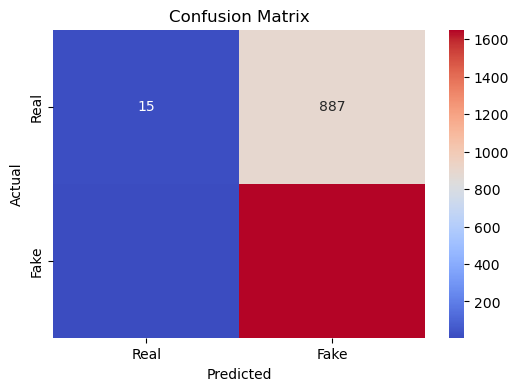

In [1]:
import torch
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load LIAR dataset (update paths if running locally)
train = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/train.tsv', sep='\t', header=None)
valid = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/valid.tsv', sep='\t', header=None)
test  = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/test.tsv', sep='\t', header=None)

# Define column names
column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job", "state", 
                "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]

train.columns = column_names
valid.columns = column_names
test.columns = column_names

# Combine datasets
liar_data = pd.concat([train, valid, test], ignore_index=True)

# Convert labels to binary (Real = 0, Fake = 1)
def binary_label(label):
    return 0 if label in ["true", "mostly-true"] else 1

liar_data['binary_label'] = liar_data['label'].apply(binary_label)

# Text Preprocessing
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()
    return text

liar_data['clean_statement'] = liar_data['statement'].astype(str).apply(clean_text)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(6, 4))
sns.countplot(x="binary_label", data=liar_data, palette="coolwarm")
plt.xticks(ticks=[0, 1], labels=["Real", "Fake"])
plt.xlabel("News Type")
plt.ylabel("Count")
plt.title("Distribution of Fake vs. Real News")
plt.show()

liar_data["word_count"] = liar_data["clean_statement"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
sns.histplot(liar_data["word_count"], bins=30, kde=True, color="purple")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Count Distribution in Articles")
plt.show()

# Split dataset into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    liar_data['clean_statement'].tolist(), liar_data['binary_label'].tolist(),
    test_size=0.2, random_state=42, stratify=liar_data['binary_label']
)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Custom PyTorch dataset class for BERT
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Create dataset objects for training and testing
train_dataset = FakeNewsDataset(train_texts, train_labels, tokenizer)
test_dataset = FakeNewsDataset(test_texts, test_labels, tokenizer)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

# Define training arguments with early stopping
training_args = TrainingArguments(
    output_dir="./bert-fake-news",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Reduced epochs for efficiency
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train BERT Model
print("\n🚀 Training BERT Model...")
trainer.train()

# Evaluate Model
print("\n🎯 Evaluating Model...")
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Calculate Performance Metrics
bert_results = {
    "Accuracy": accuracy_score(test_labels, y_pred),
    "Precision": precision_score(test_labels, y_pred),
    "Recall": recall_score(test_labels, y_pred),
    "F1-Score": f1_score(test_labels, y_pred)
}

print("\n📊 BERT Model Performance:")
for metric, value in bert_results.items():
    print(f"{metric}: {value:.4f}")

# Detailed Classification Report
print("\n🔍 Classification Report:")
print(classification_report(test_labels, y_pred, target_names=["Real", "Fake"]))

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /aul/homes/msidd040/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



🚀 Training Optimized BERT Model...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.692500,0.658287
2,0.645600,0.663546
3,0.531200,0.722027
4,0.411000,0.803210
5,0.312700,0.867972


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anac


🎯 Evaluating Optimized BERT Model...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 Updated BERT Model Performance:
Accuracy: 0.5971
Precision: 0.7468
Recall: 0.5715
F1-Score: 0.6475

🔍 Classification Report:
              precision    recall  f1-score   support

        Real       0.45      0.64      0.53       902
        Fake       0.75      0.57      0.65      1657

    accuracy                           0.60      2559
   macro avg       0.60      0.61      0.59      2559
weighted avg       0.64      0.60      0.61      2559



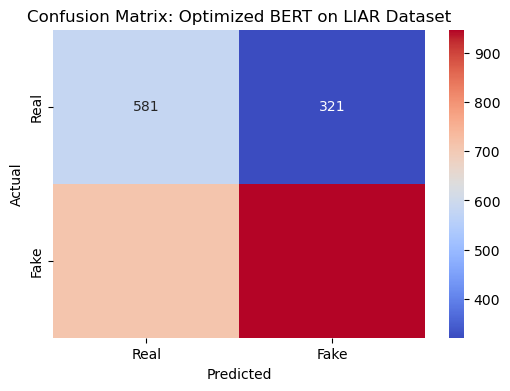

In [3]:
import torch
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
# ✅ Step 1: Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Step 2: Load LIAR Dataset
train = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/train.tsv', sep='\t', header=None)
valid = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/valid.tsv', sep='\t', header=None)
test  = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/test.tsv', sep='\t', header=None)

# Define column names
column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job", "state", 
                "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]

train.columns = column_names
valid.columns = column_names
test.columns = column_names

# Combine datasets
liar_data = pd.concat([train, valid, test], ignore_index=True)

# ✅ Step 3: Convert labels to binary (Real = 0, Fake = 1)
def binary_label(label):
    return 0 if label in ["true", "mostly-true"] else 1

liar_data['binary_label'] = liar_data['label'].apply(binary_label)

# Select relevant columns
liar_data = liar_data[["statement", "binary_label"]].dropna()

# ✅ Step 4: Text Cleaning
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

liar_data["clean_statement"] = liar_data["statement"].astype(str).apply(clean_text)

# ✅ Step 5: Split Dataset into Training & Testing Sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    liar_data["clean_statement"].tolist(), liar_data["binary_label"].tolist(),
    test_size=0.2, random_state=42, stratify=liar_data["binary_label"]
)

# ✅ Step 6: Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Step 7: Custom Dataset Class for BERT
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Create Dataset Objects
train_dataset = FakeNewsDataset(train_texts, train_labels, tokenizer)
test_dataset = FakeNewsDataset(test_texts, test_labels, tokenizer)

# ✅ Step 8: Compute Class Weights
class_counts = liar_data['binary_label'].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[0], total_samples / class_counts[1]]  # Compute weights
class_weights = torch.tensor(class_weights).to(device)

# ✅ Step 9: Define Loss Function with Class Weights
loss_fn = CrossEntropyLoss(weight=class_weights)

# ✅ Step 10: Load BERT Model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

# ✅ Step 11: Custom BERT Model Wrapper to Use Class Weights
class WeightedBERT(torch.nn.Module):
    def __init__(self, model, loss_fn):
        super(WeightedBERT, self).__init__()
        self.model = model
        self.loss_fn = loss_fn

    def forward(self, input_ids, attention_mask, labels):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# Wrap BERT Model with Class Weights
model = WeightedBERT(bert_model, loss_fn).to(device)

# ✅ Step 12: Optimized Training Arguments
training_args = TrainingArguments(
    output_dir="./bert-liar-optimized",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,  # Reduce batch size for better performance
    per_device_eval_batch_size=4,
    num_train_epochs=5,  # Fine-tune for more epochs
    learning_rate=0.0001,  # Lower learning rate for stable training
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True if torch.cuda.is_available() else False,  # Mixed precision training for GPU
)

# ✅ Step 13: Define Trainer (No `train_sampler` Error!)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# ✅ Step 14: Train the BERT Model
print("\n🚀 Training Optimized BERT Model...")
trainer.train()

# ✅ Step 15: Save Trained Model
trainer.save_model("./bert-fakenews-trained")
tokenizer.save_pretrained("./bert-fakenews-trained")

# ✅ Step 16: Evaluate the Updated Model
print("\n🎯 Evaluating Optimized BERT Model...")
predictions = trainer.predict(test_dataset)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

# Adjust Decision Threshold to Reduce False Positives
threshold = 0.6  # Increase to make BERT less likely to misclassify real news as fake
y_pred = (probs[:, 1] > threshold).numpy()

# Compute Performance Metrics
bert_results = {
    "Accuracy": accuracy_score(test_labels, y_pred),
    "Precision": precision_score(test_labels, y_pred),
    "Recall": recall_score(test_labels, y_pred),
    "F1-Score": f1_score(test_labels, y_pred)
}

print("\n📊 Updated BERT Model Performance:")
for metric, value in bert_results.items():
    print(f"{metric}: {value:.4f}")

# ✅ Step 17: Display Classification Report
print("\n🔍 Classification Report:")
print(classification_report(test_labels, y_pred, target_names=["Real", "Fake"]))

# ✅ Step 18: Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Optimized BERT on LIAR Dataset")
plt.show()


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



🚀 Training Optimized BERT Model...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.696500,0.656867
2,0.608800,0.677902
3,0.485800,0.731412
4,0.325900,0.932812
5,0.177400,1.087272


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anac


🎯 Evaluating Optimized BERT Model...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 Updated BERT Model Performance:
Accuracy: 0.6022
Precision: 0.7426
Recall: 0.5902
F1-Score: 0.6577

🔍 Classification Report:
              precision    recall  f1-score   support

        Real       0.45      0.62      0.53       902
        Fake       0.74      0.59      0.66      1657

    accuracy                           0.60      2559
   macro avg       0.60      0.61      0.59      2559
weighted avg       0.64      0.60      0.61      2559



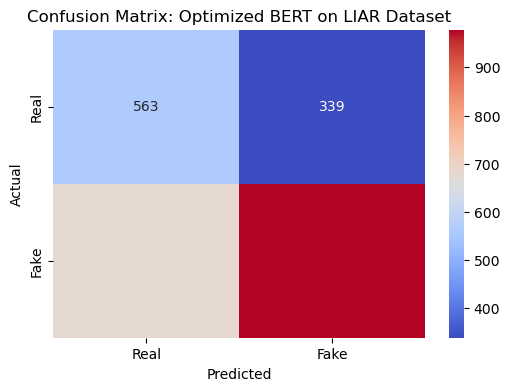

In [5]:
import torch
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
# ✅ Step 1: Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Step 2: Load LIAR Dataset
train = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/train.tsv', sep='\t', header=None)
valid = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/valid.tsv', sep='\t', header=None)
test  = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/test.tsv', sep='\t', header=None)

# Define column names
column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job", "state", 
                "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]

train.columns = column_names
valid.columns = column_names
test.columns = column_names

# Combine datasets
liar_data = pd.concat([train, valid, test], ignore_index=True)

# ✅ Step 3: Convert labels to binary (Real = 0, Fake = 1)
def binary_label(label):
    return 0 if label in ["true", "mostly-true"] else 1

liar_data['binary_label'] = liar_data['label'].apply(binary_label)

# Select relevant columns
liar_data = liar_data[["statement", "binary_label"]].dropna()

# ✅ Step 4: Text Cleaning
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()
    # text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

liar_data["clean_statement"] = liar_data["statement"].astype(str).apply(clean_text)

# ✅ Step 5: Split Dataset into Training & Testing Sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    liar_data["clean_statement"].tolist(), liar_data["binary_label"].tolist(),
    test_size=0.2, random_state=42, stratify=liar_data["binary_label"]
)

# ✅ Step 6: Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Step 7: Custom Dataset Class for BERT
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Create Dataset Objects
train_dataset = FakeNewsDataset(train_texts, train_labels, tokenizer)
test_dataset = FakeNewsDataset(test_texts, test_labels, tokenizer)

# ✅ Step 8: Compute Class Weights
class_counts = liar_data['binary_label'].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[0], total_samples / class_counts[1]]  # Compute weights
class_weights = torch.tensor(class_weights).to(device)

# ✅ Step 9: Define Loss Function with Class Weights
loss_fn = CrossEntropyLoss(weight=class_weights)

# ✅ Step 10: Load BERT Model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

# ✅ Step 11: Custom BERT Model Wrapper to Use Class Weights
class WeightedBERT(torch.nn.Module):
    def __init__(self, model, loss_fn):
        super(WeightedBERT, self).__init__()
        self.model = model
        self.loss_fn = loss_fn

    def forward(self, input_ids, attention_mask, labels):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

# Wrap BERT Model with Class Weights
model = WeightedBERT(bert_model, loss_fn).to(device)

# ✅ Step 12: Optimized Training Arguments
training_args = TrainingArguments(
    output_dir="./bert-liar-optimized",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,  # Reduce batch size for better performance
    per_device_eval_batch_size=4,
    num_train_epochs=5,  # Fine-tune for more epochs
    learning_rate=0.00003,  # Lower learning rate for stable training
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True if torch.cuda.is_available() else False,  # Mixed precision training for GPU
)

# ✅ Step 13: Define Trainer (No `train_sampler` Error!)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# ✅ Step 14: Train the BERT Model
print("\n🚀 Training Optimized BERT Model...")
trainer.train()

# ✅ Step 15: Save Trained Model
trainer.save_model("./bert-fakenews-trained")
tokenizer.save_pretrained("./bert-fakenews-trained")

# ✅ Step 16: Evaluate the Updated Model
print("\n🎯 Evaluating Optimized BERT Model...")
predictions = trainer.predict(test_dataset)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

# Adjust Decision Threshold to Reduce False Positives
threshold = 0.6  # Increase to make BERT less likely to misclassify real news as fake
y_pred = (probs[:, 1] > threshold).numpy()

# Compute Performance Metrics
bert_results = {
    "Accuracy": accuracy_score(test_labels, y_pred),
    "Precision": precision_score(test_labels, y_pred),
    "Recall": recall_score(test_labels, y_pred),
    "F1-Score": f1_score(test_labels, y_pred)
}

print("\n📊 Updated BERT Model Performance:")
for metric, value in bert_results.items():
    print(f"{metric}: {value:.4f}")

# ✅ Step 17: Display Classification Report
print("\n🔍 Classification Report:")
print(classification_report(test_labels, y_pred, target_names=["Real", "Fake"]))

# ✅ Step 18: Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Optimized BERT on LIAR Dataset")
plt.show()


In [ ]:
import torch
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Step 2: Load ISOT Fake News Dataset
true_news = pd.read_csv("/mnt/data/True.csv")
fake_news = pd.read_csv("/mnt/data/Fake.csv")

# Add Labels (Real = 0, Fake = 1)
true_news["label"] = 0
fake_news["label"] = 1

# Combine datasets
isot_data = pd.concat([true_news, fake_news], ignore_index=True)
isot_data = isot_data[["text", "label"]].dropna()

# ✅ Step 3: Load FakeNewsNet Dataset
politifact_real = pd.read_csv("/mnt/data/politifact_real.csv")
politifact_fake = pd.read_csv("/mnt/data/politifact_fake.csv")
gossipcop_real = pd.read_csv("/mnt/data/gossipcop_real.csv")
gossipcop_fake = pd.read_csv("/mnt/data/gossipcop_fake.csv")

# Add Labels (Real = 0, Fake = 1)
politifact_real["label"] = 0
politifact_fake["label"] = 1
gossipcop_real["label"] = 0
gossipcop_fake["label"] = 1

# Combine datasets
fakenewsnet_data = pd.concat([politifact_real, politifact_fake, gossipcop_real, gossipcop_fake], ignore_index=True)
fakenewsnet_data = fakenewsnet_data[["text", "label"]].dropna()

# ✅ Step 4: Text Cleaning
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()
    return text

# Apply cleaning
isot_data["clean_text"] = isot_data["text"].astype(str).apply(clean_text)
fakenewsnet_data["clean_text"] = fakenewsnet_data["text"].astype(str).apply(clean_text)

# ✅ Step 5: Split Datasets
def split_data(df):
    return train_test_split(
        df["clean_text"].tolist(), df["label"].tolist(),
        test_size=0.2, random_state=42, stratify=df["label"]
    )

train_texts_isot, test_texts_isot, train_labels_isot, test_labels_isot = split_data(isot_data)
train_texts_fnn, test_texts_fnn, train_labels_fnn, test_labels_fnn = split_data(fakenewsnet_data)

# ✅ Step 6: Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Step 7: Custom Dataset Class for BERT
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Create Dataset Objects
train_dataset_isot = FakeNewsDataset(train_texts_isot, train_labels_isot, tokenizer)
test_dataset_isot = FakeNewsDataset(test_texts_isot, test_labels_isot, tokenizer)

train_dataset_fnn = FakeNewsDataset(train_texts_fnn, train_labels_fnn, tokenizer)
test_dataset_fnn = FakeNewsDataset(test_texts_fnn, test_labels_fnn, tokenizer)

# ✅ Step 8: Compute Class Weights
def compute_class_weights(labels):
    class_counts = pd.Series(labels).value_counts().to_dict()
    total_samples = sum(class_counts.values())
    return torch.tensor([total_samples / class_counts[0], total_samples / class_counts[1]]).to(device)

class_weights_isot = compute_class_weights(train_labels_isot)
class_weights_fnn = compute_class_weights(train_labels_fnn)

# ✅ Step 9: Define Loss Function
loss_fn_isot = CrossEntropyLoss(weight=class_weights_isot)
loss_fn_fnn = CrossEntropyLoss(weight=class_weights_fnn)

# ✅ Step 10: Load BERT Model
def load_model(loss_fn):
    bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
    
    class WeightedBERT(torch.nn.Module):
        def __init__(self, model, loss_fn):
            super(WeightedBERT, self).__init__()
            self.model = model
            self.loss_fn = loss_fn

        def forward(self, input_ids, attention_mask, labels):
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = self.loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

    return WeightedBERT(bert_model, loss_fn).to(device)

model_isot = load_model(loss_fn_isot)
model_fnn = load_model(loss_fn_fnn)

# ✅ Step 11: Training Arguments
training_args = TrainingArguments(
    output_dir="./bert-fakenews-optimized",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    learning_rate=0.0001,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True if torch.cuda.is_available() else False,
)

# ✅ Step 12: Train & Evaluate
def train_and_evaluate(model, train_dataset, test_dataset, test_labels, dataset_name):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    print(f"\n🚀 Training BERT on {dataset_name} Dataset...")
    trainer.train()
    trainer.save_model(f"./bert-{dataset_name.lower()}-trained")
    tokenizer.save_pretrained(f"./bert-{dataset_name.lower()}-trained")

    print(f"\n🎯 Evaluating BERT Model on {dataset_name}...")
    predictions = trainer.predict(test_dataset)
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

    threshold = 0.6  
    y_pred = (probs[:, 1] > threshold).numpy()

    results = {
        "Accuracy": accuracy_score(test_labels, y_pred),
        "Precision": precision_score(test_labels, y_pred),
        "Recall": recall_score(test_labels, y_pred),
        "F1-Score": f1_score(test_labels, y_pred)
    }

    print(f"\n📊 {dataset_name} Model Performance:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    print("\n🔍 Classification Report:")
    print(classification_report(test_labels, y_pred, target_names=["Real", "Fake"]))

    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: BERT on {dataset_name}")
    plt.show()

# Train and Evaluate for ISOT and FakeNewsNet
train_and_evaluate(model_isot, train_dataset_isot, test_dataset_isot, test_labels_isot, "ISOT")
train_and_evaluate(model_fnn, train_dataset_fnn, test_dataset_fnn, test_labels_fnn, "FakeNewsNet")


### Complete dataset

In [7]:
import torch
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

# ✅ Step 1: Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Step 2: Load LIAR Dataset
train = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/train.tsv', sep='\t', header=None)
valid = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/valid.tsv', sep='\t', header=None)
test  = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/test.tsv', sep='\t', header=None))

column_names = ["id", "label", "statement", "subject", "speaker", "speaker_job", "state", 
                "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"]

train.columns = column_names
valid.columns = column_names
test.columns = column_names

liar_data = pd.concat([train, valid, test], ignore_index=True)

def binary_label(label):
    return 0 if label in ["true", "mostly-true"] else 1

liar_data['label'] = liar_data['label'].apply(binary_label)
liar_data = liar_data[["statement", "label"]].dropna().rename(columns={"statement": "text"})

# ✅ Step 3: Load ISOT Dataset
true_news = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/News_dataset/True.csv')
fake_news = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/News_dataset/Fake.csv')

true_news["label"] = 0
fake_news["label"] = 1

isot_data = pd.concat([true_news, fake_news], ignore_index=True)
isot_data = isot_data[["text", "label"]].dropna()

# ✅ Step 4: Load FakeNewsNet Dataset
politifact_real = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/FakeNewsNet/FakeNewsNet-master/dataset/politifact_real.csv')
politifact_fake = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/FakeNewsNet/FakeNewsNet-master/dataset/politifact_fake.csv')
gossipcop_real = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/FakeNewsNet/FakeNewsNet-master/dataset/gossipcop_real.csv')
gossipcop_fake = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/FakeNewsNet/FakeNewsNet-master/dataset/gossipcop_fake.csv')

politifact_real["label"] = 0
politifact_fake["label"] = 1
gossipcop_real["label"] = 0
gossipcop_fake["label"] = 1

fakenewsnet_data = pd.concat([politifact_real, politifact_fake, gossipcop_real, gossipcop_fake], ignore_index=True)

if "content" in fakenewsnet_data.columns:
    text_column = "content"
elif "title" in fakenewsnet_data.columns:
    text_column = "title"
else:
    text_column = "text"

fakenewsnet_data = fakenewsnet_data[[text_column, "label"]].dropna().rename(columns={text_column: "text"})

# ✅ Step 5: Merge Datasets
all_data = pd.concat([liar_data, isot_data, fakenewsnet_data], ignore_index=True)

print(f"Total samples after merging: {len(all_data)}")
print(all_data["label"].value_counts())

# ✅ Step 6: Text Preprocessing
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'[^A-Za-z\s]', '', text)  
    text = text.lower().strip()
    return text

all_data["clean_text"] = all_data["text"].astype(str).apply(clean_text)

# ✅ Step 7: Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    all_data["clean_text"].tolist(), all_data["label"].tolist(),
    test_size=0.2, random_state=42, stratify=all_data["label"]
)

# ✅ Step 8: Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Step 9: Create Dataset Class for BERT
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_dataset = FakeNewsDataset(train_texts, train_labels, tokenizer)
test_dataset = FakeNewsDataset(test_texts, test_labels, tokenizer)

# ✅ Step 10: Compute Class Weights
class_counts = all_data['label'].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[0], total_samples / class_counts[1]]
class_weights = torch.tensor(class_weights).to(device)

# ✅ Step 11: Define Loss Function
loss_fn = CrossEntropyLoss(weight=class_weights)

# ✅ Step 12: Load BERT Model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

class WeightedBERT(torch.nn.Module):
    def __init__(self, model, loss_fn):
        super(WeightedBERT, self).__init__()
        self.model = model
        self.loss_fn = loss_fn

    def forward(self, input_ids, attention_mask, labels):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

model = WeightedBERT(bert_model, loss_fn).to(device)

# ✅ Step 13: Training Arguments
training_args = TrainingArguments(
    output_dir="./bert-fakenews-merged",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True if torch.cuda.is_available() else False,
)

# ✅ Step 14: Train & Evaluate
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

print("\n🚀 Training BERT on Merged Dataset...")
trainer.train()

trainer.save_model("./bert-fakenews-merged-trained")
tokenizer.save_pretrained("./bert-fakenews-merged-trained")

# ✅ Step 15: Model Evaluation
predictions = trainer.predict(test_dataset)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

threshold = 0.6
y_pred = (probs[:, 1] > threshold).numpy()

print("\n📊 Model Performance:")
print(classification_report(test_labels, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: BERT on Merged Dataset")
plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 91)

Using device: cuda
Total samples after merging: 80885
label
0    43365
1    37520
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to
[nltk_data]     /aul/homes/msidd040/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.



🚀 Training BERT on Merged Dataset...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.188000,0.211096
2,0.172500,0.219272
3,0.119600,0.244310
4,0.108700,0.411173
5,0.150300,0.797115


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/aul/homes/msidd040/anac


📊 Model Performance:
              precision    recall  f1-score   support

        Real       0.94      0.87      0.90      8673
        Fake       0.86      0.94      0.90      7504

    accuracy                           0.90     16177
   macro avg       0.90      0.90      0.90     16177
weighted avg       0.90      0.90      0.90     16177



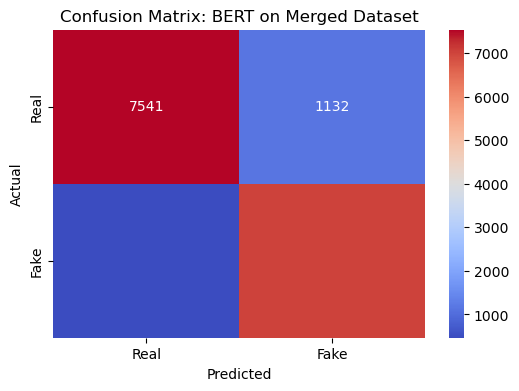

In [14]:
import torch
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

# ✅ Step 1: Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Step 2: Load LIAR Dataset
train = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/train.tsv', sep='\t', header=None)
valid = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/valid.tsv', sep='\t', header=None)
test = pd.read_csv('/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/liar_dataset/test.tsv', sep='\t', header=None)

column_names = [
    "id", "label", "statement", "subject", "speaker", "speaker_job", "state",
    "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire", "context"
]

train.columns = column_names
valid.columns = column_names
test.columns = column_names

liar_data = pd.concat([train, valid, test], ignore_index=True)

def binary_label(label):
    return 0 if label in ["true", "mostly-true"] else 1

liar_data['label'] = liar_data['label'].apply(binary_label)
liar_data = liar_data[["statement", "label"]].dropna().rename(columns={"statement": "text"})

# ✅ Step 3: Load ISOT Dataset
true_news = pd.read_csv("/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/News_dataset/True.csv")
fake_news = pd.read_csv("/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/News_dataset/Fake.csv")

true_news["label"] = 0
fake_news["label"] = 1

isot_data = pd.concat([true_news, fake_news], ignore_index=True)
isot_data = isot_data[["text", "label"]].dropna()

# ✅ Step 4: Load FakeNewsNet Dataset
politifact_real = pd.read_csv("/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/FakeNewsNet/FakeNewsNet-master/dataset/politifact_real.csv")
politifact_fake = pd.read_csv("/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/FakeNewsNet/FakeNewsNet-master/dataset/politifact_fake.csv")
gossipcop_real = pd.read_csv("/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/FakeNewsNet/FakeNewsNet-master/dataset/gossipcop_real.csv")
gossipcop_fake = pd.read_csv("/aul/homes/msidd040/Intro to Data Science (CAP 5768)/project/FakeNewsNet/FakeNewsNet-master/dataset/gossipcop_fake.csv")

politifact_real["label"] = 0
politifact_fake["label"] = 1
gossipcop_real["label"] = 0
gossipcop_fake["label"] = 1

fakenewsnet_data = pd.concat([politifact_real, politifact_fake, gossipcop_real, gossipcop_fake], ignore_index=True)

if "content" in fakenewsnet_data.columns:
    text_column = "content"
elif "title" in fakenewsnet_data.columns:
    text_column = "title"
else:
    text_column = "text"

fakenewsnet_data = fakenewsnet_data[[text_column, "label"]].dropna().rename(columns={text_column: "text"})

# ✅ Step 5: Merge Datasets
all_data = pd.concat([liar_data, isot_data, fakenewsnet_data], ignore_index=True)

print(f"Total samples after merging: {len(all_data)}")
print(all_data["label"].value_counts())

# ✅ Step 6: Text Preprocessing
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower().strip()
    return text

all_data["clean_text"] = all_data["text"].astype(str).apply(clean_text)

# ✅ Step 7: Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    all_data["clean_text"].tolist(), all_data["label"].tolist(),
    test_size=0.2, random_state=42, stratify=all_data["label"]
)

# ✅ Step 8: Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Step 9: Create Dataset Class for BERT
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_dataset = FakeNewsDataset(train_texts, train_labels, tokenizer)
test_dataset = FakeNewsDataset(test_texts, test_labels, tokenizer)

# ✅ Step 10: Compute Class Weights
class_counts = all_data['label'].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[0], total_samples / class_counts[1]]
class_weights = torch.tensor(class_weights).to(device)

# ✅ Step 11: Define Loss Function
loss_fn = CrossEntropyLoss(weight=class_weights)

# ✅ Step 12: Load BERT Model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

class WeightedBERT(torch.nn.Module):
    def __init__(self, model, loss_fn):
        super(WeightedBERT, self).__init__()
        self.model = model
        self.loss_fn = loss_fn

    def forward(self, input_ids, attention_mask, labels):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

model = WeightedBERT(bert_model, loss_fn).to(device)

# ✅ Step 13: Training Arguments
training_args = TrainingArguments(
    output_dir="./bert-fakenews-merged",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True if torch.cuda.is_available() else False,
)

# ✅ Step 14: Train & Evaluate
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

print("\n🚀 Training BERT on Merged Dataset...")
trainer.train()

trainer.save_model("./bert-fakenews-merged-trained")
tokenizer.save_pretrained("./bert-fakenews-merged-trained")

# ✅ Step 15: Model Evaluation
predictions = trainer.predict(test_dataset)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

threshold = 0.6
y_pred = (probs[:, 1] > threshold).numpy()

print("\n📊 Model Performance:")
print(classification_report(test_labels, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: BERT on Merged Dataset")
plt.show()


In [15]:
all_data

,text,label,clean_text
0,Says the Annies List political group supports ...,1,says the annies list political group supports ...
1,When did the decline of coal start? It started...,1,when did the decline of coal start it started ...
2,"Hillary Clinton agrees with John McCain ""by vo...",0,hillary clinton agrees with john mccain by vot...
3,Health care reform legislation is likely to ma...,1,health care reform legislation is likely to ma...
4,The economic turnaround started at the end of ...,1,the economic turnaround started at the end of ...
...,...,...,...
80880,September 11: Celebrities Remember 9/11 (TWEETS),1,september celebrities remember tweets
80881,NASCAR owners threaten to fire drivers who pro...,1,nascar owners threaten to fire drivers who pro...
80882,The 7 signs that David Beckham is definitely h...,1,the signs that david beckham is definitely ha...
80883,Ryan Gosling and Eva Mendes Did Not Get Marrie...,1,ryan gosling and eva mendes did not get marrie...


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 Model Performance:
              precision    recall  f1-score   support

        Real       0.97      0.81      0.88      8673
        Fake       0.82      0.97      0.89      7504

    accuracy                           0.88     16177
   macro avg       0.89      0.89      0.88     16177
weighted avg       0.90      0.88      0.88     16177



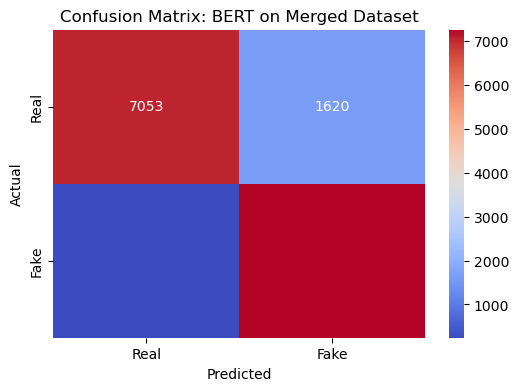

In [16]:

# ✅ Step 15: Model Evaluation
predictions = trainer.predict(test_dataset)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

threshold = 0.3
y_pred = (probs[:, 1] > threshold).numpy()

print("\n📊 Model Performance:")
print(classification_report(test_labels, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: BERT on Merged Dataset")
plt.show()

/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 Model Performance:
              precision    recall  f1-score   support

        Real       0.84      0.96      0.90      8673
        Fake       0.95      0.80      0.86      7504

    accuracy                           0.88     16177
   macro avg       0.90      0.88      0.88     16177
weighted avg       0.89      0.88      0.88     16177



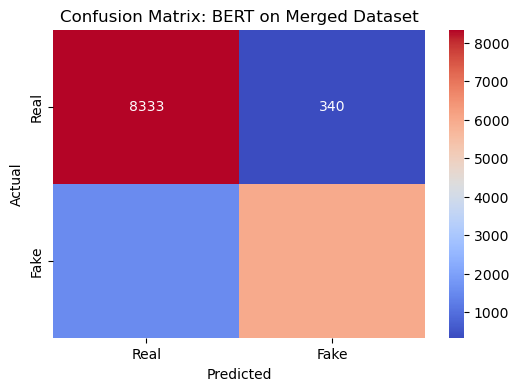

In [17]:

# ✅ Step 15: Model Evaluation
predictions = trainer.predict(test_dataset)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

threshold = 0.8
y_pred = (probs[:, 1] > threshold).numpy()

print("\n📊 Model Performance:")
print(classification_report(test_labels, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: BERT on Merged Dataset")
plt.show()

In [18]:
import random
import pandas as pd

# ✅ Get model predictions and probabilities
predictions = trainer.predict(test_dataset)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

# ✅ Convert to DataFrame
test_results = pd.DataFrame({
    "text": test_texts,  
    "actual_label": test_labels,  
    "predicted_label": (probs[:, 1] > threshold).astype(int),  
    "fake_probability": probs[:, 1]  # Confidence score for Fake label
})

# ✅ Find Different Types of Predictions
true_positives = test_results[(test_results["actual_label"] == 1) & (test_results["predicted_label"] == 1)]
true_negatives = test_results[(test_results["actual_label"] == 0) & (test_results["predicted_label"] == 0)]
false_positives = test_results[(test_results["actual_label"] == 0) & (test_results["predicted_label"] == 1)]
false_negatives = test_results[(test_results["actual_label"] == 1) & (test_results["predicted_label"] == 0)]

# ✅ Function to Display Sample Predictions
def show_samples(df, label, num_samples=3):
    print(f"\n🔍 Sample {label} News Predictions:")
    sample_rows = df.sample(min(num_samples, len(df)), random_state=42)  # Pick random examples
    for index, row in sample_rows.iterrows():
        print(f"\n📢 **News Text:** {row['text']}")
        print(f"🎯 **Actual Label:** {'Fake' if row['actual_label'] == 1 else 'Real'}")
        print(f"🤖 **Predicted Label:** {'Fake' if row['predicted_label'] == 1 else 'Real'}")
        print(f"📊 **Fake Probability:** {row['fake_probability']:.2f}")
        print("-" * 80)

# ✅ Show Examples for Each Category
show_samples(true_positives, "Correct Fake News (True Positives)")
show_samples(true_negatives, "Correct Real News (True Negatives)")
show_samples(false_positives, "Misclassified Fake as Real (False Positives)")
show_samples(false_negatives, "Misclassified Real as Fake (False Negatives)")


/aul/homes/msidd040/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



🔍 Sample Correct Fake News (True Positives) News Predictions:

📢 **News Text:** since corey stewart became chairman in november  unemployment is up  and average home price sales are down
🎯 **Actual Label:** Fake
🤖 **Predicted Label:** Fake
📊 **Fake Probability:** 0.83
--------------------------------------------------------------------------------

📢 **News Text:** kendall   kylie jenner jenner not upset upset over caitlyn engagement engagement despite report
🎯 **Actual Label:** Fake
🤖 **Predicted Label:** Fake
📊 **Fake Probability:** 0.98
--------------------------------------------------------------------------------

📢 **News Text:** houston texas trial lawyer and democrat megadonor steve mostyn died on thursday in what authorities are saying was a  suicide  according to the houston chronicle mr mostyn was only  he left behind a wife and several children and earlier this year had announced that he was going to be stepping away from politics to spend more time with his familydetails

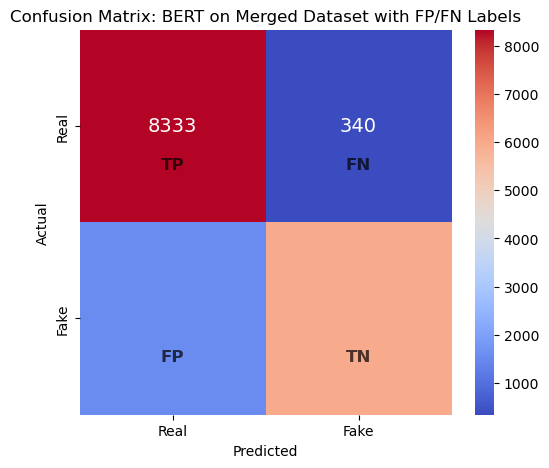

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

# Labels
labels = ["Real", "Fake"]

# ✅ Create a labeled confusion matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})

# ✅ Add TP, TN, FP, FN labels **below** the numbers for clarity
for i in range(2):
    for j in range(2):
        text_label = ""
        if i == 0 and j == 0:
            text_label = "TP"  # True Positive
        elif i == 1 and j == 1:
            text_label = "TN"  # True Negative
        elif i == 1 and j == 0:
            text_label = "FP"  # False Positive
        elif i == 0 and j == 1:
            text_label = "FN"  # False Negative

        # ✅ Position FP/FN/TP/TN **below the number** to avoid overlap
        ax.text(j + 0.5, i + 0.7, text_label, ha="center", va="center",
                color="black", fontsize=12, fontweight="bold", alpha=0.7)

# ✅ Titles and Labels
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: BERT on Merged Dataset with FP/FN Labels")

plt.show()


In [26]:
test_labels

[0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,


In [21]:
y_pred

array([False, False,  True, ..., False,  True, False])

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Convert y_pred from boolean to integer (0 and 1)
y_pred = np.array(y_pred, dtype=int)

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

# Print Confusion Matrix
print("\n✅ Fixed Confusion Matrix:")
print(cm)



✅ Fixed Confusion Matrix:
[[8333  340]
 [1534 5970]]


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
# ✅ Step 15: Model Evaluation
predictions = trainer.predict(test_dataset)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

threshold = 0.3
y_pred = (probs[:, 1] > threshold).numpy()



# Convert y_pred from boolean to integer (0 and 1)
y_pred = np.array(y_pred, dtype=int)

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

# Print Confusion Matrix
print("\n✅ Fixed Confusion Matrix:")
print(cm)

